In [6]:
## Standard libraries
import os
import json
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch
import torchvision
import torchvision.transforms as transforms

from omnivault.utils.reproducibility.seed import seed_all


/var/folders/l2/jjqj299126j0gycr9kkkt9xm0000gn/T/ipykernel_50178/323648431.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [2]:
seed_all(42, seed_torch=True, set_torch_deterministic=False)

42

In [13]:
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cpu


In [3]:
class ActivationFunction(nn.Module):

    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}

##############################

class Sigmoid(ActivationFunction):

    def forward(self, x):
        return 1 / (1 + torch.exp(-x))

##############################

class Tanh(ActivationFunction):

    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)

##############################

##############################

class ReLU(ActivationFunction):

    def forward(self, x):
        return x * (x > 0).float()

##############################

class LeakyReLU(ActivationFunction):

    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha

    def forward(self, x):
        return torch.where(x > 0, x, self.config["alpha"] * x)

##############################

class ELU(ActivationFunction):

    def forward(self, x):
        return torch.where(x > 0, x, torch.exp(x)-1)

##############################

class Swish(ActivationFunction):

    def forward(self, x):
        return x * torch.sigmoid(x)

##############################

act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": ReLU,
    "leakyrelu": LeakyReLU,
    "elu": ELU,
    "swish": Swish
}


def get_grads(act_fn, x):
    """
    Computes the gradients of an activation function at specified positions.

    Inputs:
        act_fn - An object of the class "ActivationFunction" with an implemented forward pass.
        x - 1D input tensor.
    Output:
        A tensor with the same size of x containing the gradients of act_fn at x.
    """
    x = x.clone().requires_grad_() # Mark the input as tensor for which we want to store gradients
    out = act_fn(x)
    out.sum().backward() # Summing results in an equal gradient flow to each element in x
    return x.grad # Accessing the gradients of x by "x.grad"

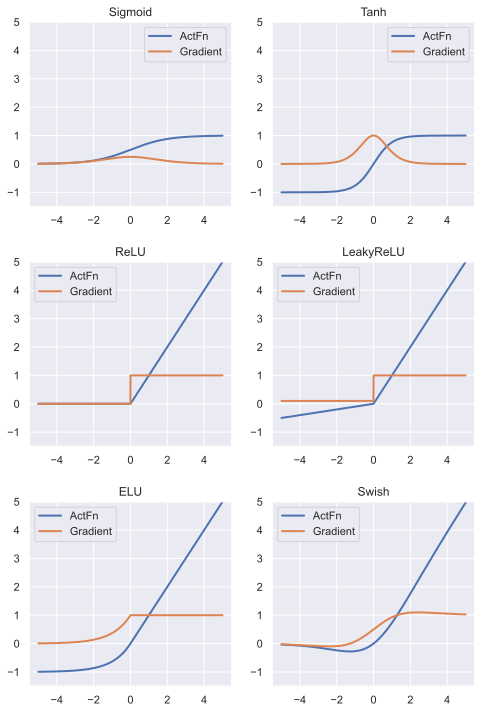

In [4]:
def vis_act_fn(act_fn, ax, x):
    # Run activation function
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    # Push x, y and gradients back to cpu for plotting
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    ## Plotting
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())

# Add activation functions if wanted
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = torch.linspace(-5, 5, 1000) # Range on which we want to visualize the activation functions
## Plotting
rows = math.ceil(len(act_fns)/2.0)
fig, ax = plt.subplots(rows, 2, figsize=(8, rows*4))
for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i,2)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()

In [20]:
class BaseNetwork(nn.Module):

    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Inputs:
            act_fn - Object of the activation function that should be used as non-linearity in the network.
            input_size - Size of the input images in pixels
            num_classes - Number of classes we want to predict
            hidden_sizes - A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.Sequential(*layers) # nn.Sequential summarizes a list of modules into a single module, applying them in sequence

        # We store all hyperparameters in a dictionary for saving and loading of the model
        self.config = {"act_fn": act_fn.config, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes}

    def forward(self, x):
        x = x.view(x.size(0), -1) # Reshape images to a flat vector
        print(x.shape)
        out = self.layers(x)
        return out

In [18]:
train_set[0][0].shape, 32*32

(torch.Size([3, 32, 32]), 1024)

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)



100%|██████████| 170498071/170498071 [00:13<00:00, 12804401.51it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [10]:
train_set, val_set = torch.utils.data.random_split(train_dataset, [40000, 10000])
test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified


In [11]:
# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

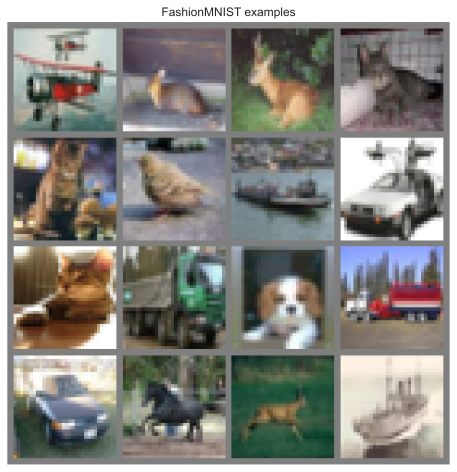

In [12]:
exmp_imgs = [train_set[i][0] for i in range(16)]
# Organize the images into a grid for nicer visualization
img_grid = torchvision.utils.make_grid(torch.stack(exmp_imgs, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("FashionMNIST examples")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [14]:
def visualize_gradients(net, color="C0"):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=256, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    net.zero_grad()
    preds = net(imgs)
    loss = F.cross_entropy(preds, labels)
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {name: params.grad.data.view(-1).cpu().clone().numpy() for name, params in net.named_parameters() if "weight" in name}
    net.zero_grad()

    ## Plotting
    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3.5, 2.5))
    fig_index = 0
    for key in grads:
        key_ax = ax[fig_index%columns]
        sns.histplot(data=grads[key], bins=30, ax=key_ax, color=color, kde=True)
        key_ax.set_title(str(key))
        key_ax.set_xlabel("Grad magnitude")
        fig_index += 1
    fig.suptitle(f"Gradient magnitude distribution for activation function {net.config['act_fn']['name']}", fontsize=14, y=1.05)
    fig.subplots_adjust(wspace=0.45)
    plt.show()
    plt.close()

torch.Size([256, 3072])


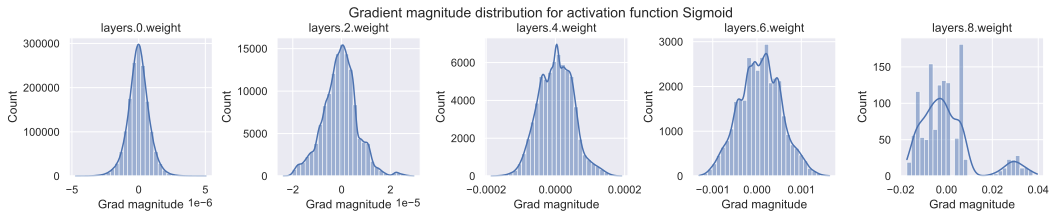

torch.Size([256, 3072])


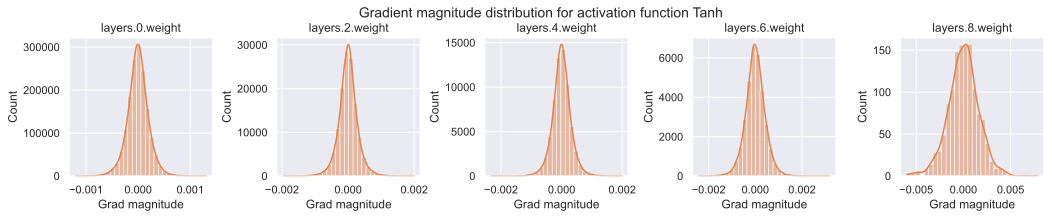

torch.Size([256, 3072])


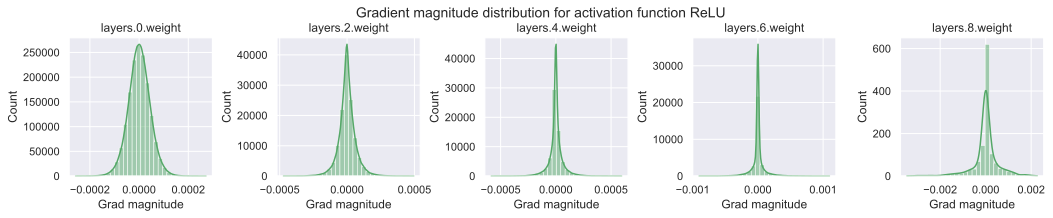

torch.Size([256, 3072])


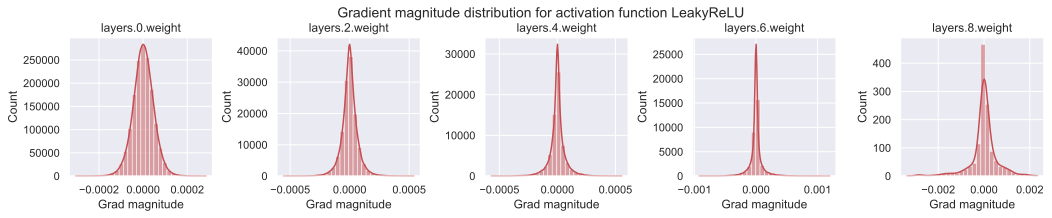

torch.Size([256, 3072])


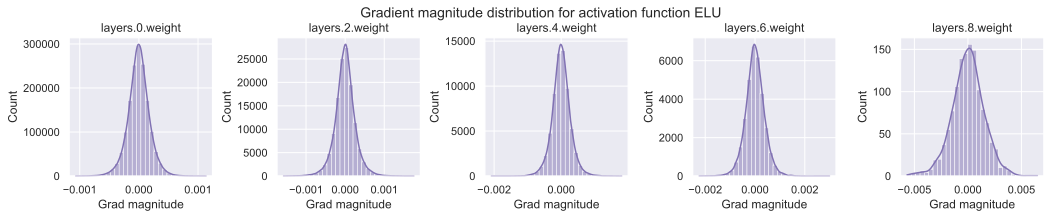

torch.Size([256, 3072])


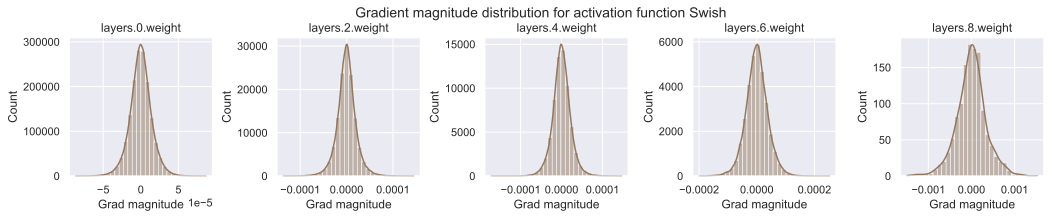

In [22]:
# Seaborn prints warnings if histogram has small values. We can ignore them for now
import warnings
warnings.filterwarnings('ignore')
## Create a plot for every activation function
for i, act_fn_name in enumerate(act_fn_by_name):
    seed_all(42, seed_torch=True, set_torch_deterministic=False) # Setting the seed ensures that we have the same weight initialization for each activation function
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn, input_size=32*32*3).to(device)
    visualize_gradients(net_actfn, color=f"C{i}")